In [1]:
# Libraries import
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
import re
import time
import gc
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import linear_model, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV , train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

Pour cette étape, j'ai choisi de m'appuyer sur le kernel Kaggle suivant:(https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features)


In [2]:
df_data_mod = pd.read_csv('Data/Home_credit_risk_data_modeling.csv', index_col=0)
df_data_mod.info()
columns_no_nan = [i for i in df_data_mod.columns if df_data_mod[i].isnull().sum() == 0]
df_train_sample = df_data_mod.loc[~(df_data_mod['TARGET'].isnull())]
df_test_sample = df_data_mod.loc[df_data_mod['TARGET'].isnull()]
del df_data_mod
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(622), int64(175)
memory usage: 2.1 GB


0

In [4]:
# Defining X and y with train data
X = df_train_sample.drop(columns = ['TARGET','SK_ID_CURR']).copy()
y = df_train_sample['TARGET'].copy()
# keep SK_ID_CURR for later evantually
index_global_train_SK_ID_CURR = df_train_sample['SK_ID_CURR']
# Checking inf
np.isinf(X).values.sum()

20

In [5]:
# Replace inf values by max() and min() values and check
col_min_max = {np.inf: X[np.isfinite(X)].max(),    # column-wise max
              -np.inf: X[np.isfinite(X)].min()}    # column-wise min

X = X.replace({col: col_min_max for col in X.columns})
np.isinf(X).values.sum()

0

In [6]:
# Checking NaN values
X.isna().sum()

CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
CNT_CHILDREN                             0
AMT_INCOME_TOTAL                         0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     220602
CC_NAME_CONTRACT_STATUS_nan_MEAN    220602
CC_NAME_CONTRACT_STATUS_nan_SUM     220602
CC_NAME_CONTRACT_STATUS_nan_VAR     221234
CC_COUNT                            220602
Length: 795, dtype: int64

In [7]:
# Function for features detection before imputation, numerical continue or numerical discrete
def list_features_att(df):
    '''Function to attribute to columns of a dataframe a category into a several list
    it returns two lists.
    --> Numerical: num_list
    --> discrete_numerical: num_dis_list'''
    
    num_list = list()
    num_dis_list = list()
    for name in df.columns:
        if df[name].nunique() < 10:
            num_dis_list.append(name)
        else:
            num_list.append(name)
    return num_list, num_dis_list

In [8]:
# Imputation in function of the numeric format
numerical_cont_list, numerical_disc_list = list_features_att(X)
time_init = time.time()
#imputation on numeric continue columns with 'mean' strategy
X[numerical_cont_list] = SimpleImputer(strategy='mean').fit_transform(X[numerical_cont_list])
#imputation on  discrete numeric columns with 'most_frequent' strategy
X[numerical_disc_list] = SimpleImputer(strategy='most_frequent').fit_transform(X[numerical_disc_list])
print (f'time for imputation: {time.time() - time_init:.2f}')

time for imputation: 26.64


* Nous avons 795 features et 307507 lignes ! nous allons réduire  nos données avec train_test_split avec option stratifiée pour conserver 5% de nos données.
* Il ne sera utilisé que pour la recherche d'un meilleur modèle potentiel

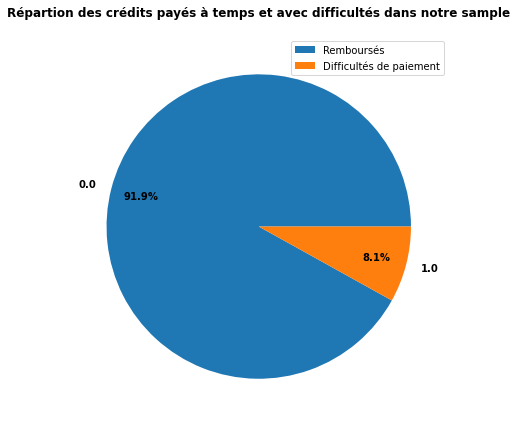

sample features shape:(15375, 795), sample target shape: (15375,)


In [9]:
# keeping only train result in our split
X1,_,y1,_ = train_test_split(X, y, train_size=0.05, stratify=y, random_state=4)
# verifying that our problem is still imbalanced
figure1 = plt.figure(figsize=(10,7), facecolor='w')
plt.title('Répartion des crédits payés à temps et avec difficultés dans notre sample', fontweight='bold', pad=20)
plt.axis('off')
x = y1.value_counts()
expl = [0 if i/x.sum() > 0.02 else 0.8 for i in x]
plt.pie(x, labels=[i for i in x.index], autopct="%.1f%%", pctdistance=0.8,
        explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.legend(['Remboursés', 'Difficultés de paiement'])
plt.show()
print(f'sample features shape:{X1.shape}, sample target shape: {y1.shape}')

* Nous avons obtenu 15375 lignes avec le même état déséquilibré que nos données complètes.

* Maintenant, nous allons appliquer le split  et le standardScaler aux données réduites avant de rechercher le meilleur modèle.

In [10]:
time_init = time.time()
# Data split (80% of train set)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.8, stratify=y1, random_state=4)
# Normalization of the imput data
std_scaler = StandardScaler()
std_scaler.fit(X1_train)
X1_train = std_scaler.transform(X1_train)
X1_test = std_scaler.transform(X1_test)
print (f'Time for Spliting and Normalize: {time.time() - time_init:.2f}')

Time for Spliting and Normalize: 0.28


## Recherche du meilleur modèle ( SMOTE, RUS ) pour ré-échantillonner le jeu de données :

Nous pouvons corriger cette situation via le rééchantillonnage :

* **undersampling (sous-échantillonnage ):** éléments pop de la classe la plus lourde. Méthode des liens Tomek de la bibliothèque imblearn
suréchantillonnage : ajouter des éléments dans la classe mineure. Méthode SMOTE de la bibliothèque imblearn
* **RandomUnderSampler :** Cette méthode supprime la classe la plus lourde en sélectionnant aléatoirement des échantillons avec ou sans remplacement

### 1. Dummy Classifier :
Il va nous servir comme baseline. 

In [11]:
dummy_classifier= DummyClassifier(strategy='most_frequent', random_state=4)
time_init = time.time()
dummy_classifier.fit(X1_train, y1_train)
time_1 = time.time()
y_pred_dumm_const_1 = dummy_classifier.predict(X1_test)
time_2 = time.time()
y_pred_pro_dumm_const_1 = dummy_classifier.predict_proba(X1_test)[:,1]
# create df for global model results
summary_result = list()
summary_result.append({'model':'Dummy_stratified', 'Score AUC':roc_auc_score(y1_test, y_pred_pro_dumm_const_1), 
                       'F1_score': f1_score(y1_test, y_pred_dumm_const_1), 'F2_score': fbeta_score(y1_test, y_pred_dumm_const_1, beta=2), 
                       'Precision_score': precision_score(y1_test,y_pred_dumm_const_1), 'Recall_score': recall_score(y1_test, y_pred_dumm_const_1),
                       'Train Time(s)':time_1 - time_init, 'Predict Time(s)': time_2 - time_1,'Comment': 'test data score'})
df_summary_result1 = pd.DataFrame(summary_result)
df_summary_result1

C:\Users\Fadou\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,Score AUC,F1_score,F2_score,Precision_score,Recall_score,Train Time(s),Predict Time(s),Comment
0,Dummy_stratified,0.5,0.0,0.0,0.0,0.0,0.001998,0.0,test data score


###  2. Sélection des model avec  RandomSearchCV :

#### 2.1  Logistic Regression

In [12]:
# Defining the samplers
smote = SMOTE(random_state=4)
rus = RandomUnderSampler(random_state=4)

# create the imblearn pipeline and grid parameters
# be carefull be sure to use pipeline from imblearn to use SMOTE sampler, it will not evaluate result on y_test create with it
time_init = time.time()
scores_CV5_1 = list()
for sampler in [smote, rus]:
    pipe = Pipeline([('Sampling', sampler), ('classifier', linear_model.LogisticRegression(random_state=4, max_iter=10000))])
    param_grid1 = {'classifier__C':np.logspace(1,3,100)}
    # perfomring rand search CV
    gride_mod = RandomizedSearchCV(pipe, param_distributions = param_grid1, cv = 5, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=4)
    gride_mod.fit(X1_train, y1_train)
    scores_CV5_1.append({'model':'Logistic_Regression', 'best_score AUC':gride_mod.best_score_, 'best parameters':gride_mod.best_params_,
                       'Best model':gride_mod.best_estimator_,'Refit Time(s)':gride_mod.refit_time_, 'Comment':f'{sampler} train data'})

# create df results
print(f'RandomSearchCV execution time(s): {time.time() - time_init}')
df_scores_CV5_1 = pd.DataFrame(scores_CV5_1)
df_scores_CV5_1

RandomSearchCV execution time(s): 2650.2927453517914


,model,best_score AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic_Regression,0.684624,{'classifier__C': 15.922827933410922},"(SMOTE(random_state=4), LogisticRegression(C=1...",35.559556,SMOTE(random_state=4) train data
1,Logistic_Regression,0.651584,{'classifier__C': 15.922827933410922},"(RandomUnderSampler(random_state=4), LogisticR...",2.073801,RandomUnderSampler(random_state=4) train data


#### 2.2. KNeighborsClassifier

In [13]:
# Defining the samplers
smote = SMOTE(random_state=4)
rus = RandomUnderSampler(random_state=4)

# create the imblearn pipeline and grid parameters
# be carefull be sure to use pipeline from imblearn to use SMOTE sampler, it will not evaluate result on y_test create with it
time_init = time.time()
scores_CV5_1 = list()
for sampler in [smote, rus]:
    pipe = Pipeline([('Sampling', sampler), ('classifier', neighbors.KNeighborsClassifier())])
    param_grid1 = {'classifier__n_neighbors':range(2,300,1)}
    # perfomring rand search CV
    gride_mod = RandomizedSearchCV(pipe, param_distributions = param_grid1, cv = 5, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=4)
    gride_mod.fit(X1_train, y1_train)
    scores_CV5_1.append({'model':'Kneighbors classifier', 'best_score AUC':gride_mod.best_score_, 'best parameters':gride_mod.best_params_,
                       'Best model':gride_mod.best_estimator_,'Refit Time(s)':gride_mod.refit_time_, 'Comment':f'{sampler} train data'})
   
    # create df results
    print(f'RandomSearchCV execution time(s): {time.time() - time_init}')
    df_scores_CV5_1 = df_scores_CV5_1.append(scores_CV5_1, ignore_index=True)


RandomSearchCV execution time(s): 71.70884013175964
RandomSearchCV execution time(s): 80.35434937477112


In [26]:
 df_scores_CV5_1

,model,best_score AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic_Regression,0.684624,{'classifier__C': 15.922827933410922},"(SMOTE(random_state=4), LogisticRegression(C=1...",35.559556,SMOTE(random_state=4) train data
1,Logistic_Regression,0.651584,{'classifier__C': 15.922827933410922},"(RandomUnderSampler(random_state=4), LogisticR...",2.073801,RandomUnderSampler(random_state=4) train data
2,Kneighbors classifier,0.591673,{'classifier__n_neighbors': 291},"(SMOTE(random_state=4), KNeighborsClassifier(n...",0.390617,SMOTE(random_state=4) train data
3,Kneighbors classifier,0.591673,{'classifier__n_neighbors': 291},"(SMOTE(random_state=4), KNeighborsClassifier(n...",0.390617,SMOTE(random_state=4) train data
4,Kneighbors classifier,0.671466,{'classifier__n_neighbors': 293},"(RandomUnderSampler(random_state=4), KNeighbor...",0.015625,RandomUnderSampler(random_state=4) train data
5,RandomForest classifier,0.685239,"{'classifier__n_estimators': 65, 'classifier__...","(SMOTE(random_state=4), (DecisionTreeClassifie...",10.386787,SMOTE(random_state=4) train data
6,RandomForest classifier,0.719367,"{'classifier__n_estimators': 50, 'classifier__...","(RandomUnderSampler(random_state=4), (Decision...",0.453113,RandomUnderSampler(random_state=4) train data
7,XGBoost classifier,0.731914,"{'classifier__n_estimators': 60, 'classifier__...","(SMOTE(random_state=4), XGBClassifier(base_sco...",30.916036,SMOTE(random_state=4) train data
8,XGBoost classifier,0.729597,"{'classifier__n_estimators': 25, 'classifier__...","(RandomUnderSampler(random_state=4), XGBClassi...",0.766528,RandomUnderSampler(random_state=4) train data
9,LGBM classifier,0.732245,"{'classifier__n_estimators': 60, 'classifier__...","(SMOTE(random_state=4), LGBMClassifier(max_dep...",6.158206,SMOTE(random_state=4) train data


####  2.3. RandomForest Classifier

In [14]:
# create the imblearn pipeline and grid parameters
# be carefull be sure to use pipeline from imblearn to use SMOTE sampler, it will not evaluate result on y_test create with it
time_init = time.time()
scores_CV5_1 = list()
for sampler in [smote, rus]:
    pipe = Pipeline([('Sampling', sampler), ('classifier', RandomForestClassifier(random_state=4))])
    param_grid1 = {'classifier__n_estimators':range(5,70,5), 'classifier__max_depth': [5, 7, 10]}
    # perfomring rand search CV
    gride_mod = RandomizedSearchCV(pipe, param_distributions = param_grid1, cv = 5, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=4)
    gride_mod.fit(X1_train, y1_train)
    scores_CV5_1.append({'model':'RandomForest classifier', 'best_score AUC':gride_mod.best_score_, 'best parameters':gride_mod.best_params_,
                       'Best model':gride_mod.best_estimator_,'Refit Time(s)':gride_mod.refit_time_, 'Comment':f'{sampler} train data'})

# create df results
print(f'RandomSearchCV execution time(s): {time.time() - time_init}')
df_scores_CV5_1 = df_scores_CV5_1.append(scores_CV5_1, ignore_index=True)
df_scores_CV5_1

RandomSearchCV execution time(s): 67.9321939945221


,model,best_score AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic_Regression,0.684624,{'classifier__C': 15.922827933410922},"(SMOTE(random_state=4), LogisticRegression(C=1...",35.559556,SMOTE(random_state=4) train data
1,Logistic_Regression,0.651584,{'classifier__C': 15.922827933410922},"(RandomUnderSampler(random_state=4), LogisticR...",2.073801,RandomUnderSampler(random_state=4) train data
2,Kneighbors classifier,0.591673,{'classifier__n_neighbors': 291},"(SMOTE(random_state=4), KNeighborsClassifier(n...",0.390617,SMOTE(random_state=4) train data
3,Kneighbors classifier,0.591673,{'classifier__n_neighbors': 291},"(SMOTE(random_state=4), KNeighborsClassifier(n...",0.390617,SMOTE(random_state=4) train data
4,Kneighbors classifier,0.671466,{'classifier__n_neighbors': 293},"(RandomUnderSampler(random_state=4), KNeighbor...",0.015625,RandomUnderSampler(random_state=4) train data
5,RandomForest classifier,0.685239,"{'classifier__n_estimators': 65, 'classifier__...","(SMOTE(random_state=4), (DecisionTreeClassifie...",10.386787,SMOTE(random_state=4) train data
6,RandomForest classifier,0.719367,"{'classifier__n_estimators': 50, 'classifier__...","(RandomUnderSampler(random_state=4), (Decision...",0.453113,RandomUnderSampler(random_state=4) train data


####  2.4. XGBoost classifier

In [15]:
# create the imblearn pipeline and grid parameters
# be carefull be sure to use pipeline from imblearn to use SMOTE sampler, it will not evaluate result on y_test create with it
time_init = time.time()
scores_CV5_1 = list()
for sampler in [smote, rus]:
    pipe = Pipeline([('Sampling', sampler), ('classifier', XGBClassifier(use_label_encoder=False, random_state=4, eval_metric='mlogloss'))])
    param_grid1 = {'classifier__n_estimators':range(5,70,5), 'classifier__max_depth': [5, 7, 10], 'classifier__learning_rate':[0.1, 0.5]}
    # perfomring rand search CV
    gride_mod = RandomizedSearchCV(pipe, param_distributions = param_grid1, cv = 5, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=4)
    gride_mod.fit(X1_train, y1_train)
    scores_CV5_1.append({'model':'XGBoost classifier', 'best_score AUC':gride_mod.best_score_, 'best parameters':gride_mod.best_params_,
                       'Best model':gride_mod.best_estimator_,'Refit Time(s)':gride_mod.refit_time_, 'Comment':f'{sampler} train data'})

# create df results
print(f'RandomSearchCV execution time(s): {time.time() - time_init}')
df_scores_CV5_1 = df_scores_CV5_1.append(scores_CV5_1, ignore_index=True)
df_scores_CV5_1

RandomSearchCV execution time(s): 720.9838423728943


,model,best_score AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic_Regression,0.684624,{'classifier__C': 15.922827933410922},"(SMOTE(random_state=4), LogisticRegression(C=1...",35.559556,SMOTE(random_state=4) train data
1,Logistic_Regression,0.651584,{'classifier__C': 15.922827933410922},"(RandomUnderSampler(random_state=4), LogisticR...",2.073801,RandomUnderSampler(random_state=4) train data
2,Kneighbors classifier,0.591673,{'classifier__n_neighbors': 291},"(SMOTE(random_state=4), KNeighborsClassifier(n...",0.390617,SMOTE(random_state=4) train data
3,Kneighbors classifier,0.591673,{'classifier__n_neighbors': 291},"(SMOTE(random_state=4), KNeighborsClassifier(n...",0.390617,SMOTE(random_state=4) train data
4,Kneighbors classifier,0.671466,{'classifier__n_neighbors': 293},"(RandomUnderSampler(random_state=4), KNeighbor...",0.015625,RandomUnderSampler(random_state=4) train data
5,RandomForest classifier,0.685239,"{'classifier__n_estimators': 65, 'classifier__...","(SMOTE(random_state=4), (DecisionTreeClassifie...",10.386787,SMOTE(random_state=4) train data
6,RandomForest classifier,0.719367,"{'classifier__n_estimators': 50, 'classifier__...","(RandomUnderSampler(random_state=4), (Decision...",0.453113,RandomUnderSampler(random_state=4) train data
7,XGBoost classifier,0.731914,"{'classifier__n_estimators': 60, 'classifier__...","(SMOTE(random_state=4), XGBClassifier(base_sco...",30.916036,SMOTE(random_state=4) train data
8,XGBoost classifier,0.729597,"{'classifier__n_estimators': 25, 'classifier__...","(RandomUnderSampler(random_state=4), XGBClassi...",0.766528,RandomUnderSampler(random_state=4) train data


####  2.5. LGBM classifier

In [16]:
# create the imblearn pipeline and grid parameters
# be carefull be sure to use pipeline from imblearn to use SMOTE sampler, it will not evaluate result on y_test create with it
time_init = time.time()
scores_CV5_1 = list()
for sampler in [smote, rus]:
    pipe = Pipeline([('Sampling', sampler), ('classifier', LGBMClassifier(random_state=4))])
    param_grid1 = {'classifier__n_estimators':range(5,70,5), 'classifier__max_depth': [5, 7, 10], 'classifier__learning_rate':[0.1, 0.5]}
    # perfomring rand search CV
    gride_mod = RandomizedSearchCV(pipe, param_distributions = param_grid1, cv = 5, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=4)
    gride_mod.fit(X1_train, y1_train)
    scores_CV5_1.append({'model':'LGBM classifier', 'best_score AUC':gride_mod.best_score_, 'best parameters':gride_mod.best_params_,
                       'Best model':gride_mod.best_estimator_,'Refit Time(s)':gride_mod.refit_time_, 'Comment':f'{sampler} train data'})

# create df results
print(f'RandomSearchCV execution time(s): {time.time() - time_init}')
df_scores_CV5_1 = df_scores_CV5_1.append(scores_CV5_1, ignore_index=True)
df_scores_CV5_1

RandomSearchCV execution time(s): 168.84985613822937


,model,best_score AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic_Regression,0.684624,{'classifier__C': 15.922827933410922},"(SMOTE(random_state=4), LogisticRegression(C=1...",35.559556,SMOTE(random_state=4) train data
1,Logistic_Regression,0.651584,{'classifier__C': 15.922827933410922},"(RandomUnderSampler(random_state=4), LogisticR...",2.073801,RandomUnderSampler(random_state=4) train data
2,Kneighbors classifier,0.591673,{'classifier__n_neighbors': 291},"(SMOTE(random_state=4), KNeighborsClassifier(n...",0.390617,SMOTE(random_state=4) train data
3,Kneighbors classifier,0.591673,{'classifier__n_neighbors': 291},"(SMOTE(random_state=4), KNeighborsClassifier(n...",0.390617,SMOTE(random_state=4) train data
4,Kneighbors classifier,0.671466,{'classifier__n_neighbors': 293},"(RandomUnderSampler(random_state=4), KNeighbor...",0.015625,RandomUnderSampler(random_state=4) train data
5,RandomForest classifier,0.685239,"{'classifier__n_estimators': 65, 'classifier__...","(SMOTE(random_state=4), (DecisionTreeClassifie...",10.386787,SMOTE(random_state=4) train data
6,RandomForest classifier,0.719367,"{'classifier__n_estimators': 50, 'classifier__...","(RandomUnderSampler(random_state=4), (Decision...",0.453113,RandomUnderSampler(random_state=4) train data
7,XGBoost classifier,0.731914,"{'classifier__n_estimators': 60, 'classifier__...","(SMOTE(random_state=4), XGBClassifier(base_sco...",30.916036,SMOTE(random_state=4) train data
8,XGBoost classifier,0.729597,"{'classifier__n_estimators': 25, 'classifier__...","(RandomUnderSampler(random_state=4), XGBClassi...",0.766528,RandomUnderSampler(random_state=4) train data
9,LGBM classifier,0.732245,"{'classifier__n_estimators': 60, 'classifier__...","(SMOTE(random_state=4), LGBMClassifier(max_dep...",6.158206,SMOTE(random_state=4) train data


 #### Score de validation  sur des données réduites : 

In [17]:
# create list with probability on the validation test
y_pred_prob_list = list()
# add dummy classifier result to problist for our basline
y_pred_prob_list.append(y_pred_pro_dumm_const_1)
# Results for each best models with test data
for i in df_scores_CV5_1.index:
    model = df_scores_CV5_1.iloc[i,3]
    time_init = time.time()
    time_1 = time.time()
    y_pred_model = model.predict(X1_test)
    time_2 = time.time()
    y_pred_prob_model = model.predict_proba(X1_test)[:,1]
    # filling df with results for each models
    summary_result = list()
    summary_result.append({'model': df_scores_CV5_1.iloc[i, 0], 'Score AUC':roc_auc_score(y1_test, y_pred_prob_model), 
                       'F1_score': f1_score(y1_test, y_pred_model), 'F2_score': fbeta_score(y1_test, y_pred_model, beta=2),
                        'Precision_score': precision_score(y1_test,y_pred_model), 'Recall_score': recall_score(y1_test, y_pred_model),
                       'Train Time(s)':df_scores_CV5_1.iloc[i, 4], 'Predict Time(s)': time_2 - time_1 , 
                        'Comment': f'test data score with {df_scores_CV5_1.iloc[i, 5]}'})
    df_summary_result1 = df_summary_result1.append(summary_result, ignore_index=True)
    y_pred_prob_list.append(y_pred_prob_model)
df_summary_result1

,model,Score AUC,F1_score,F2_score,Precision_score,Recall_score,Train Time(s),Predict Time(s),Comment
0,Dummy_stratified,0.500000,0.000000,0.000000,0.000000,0.000000,0.001998,0.000000,test data score
1,Logistic_Regression,0.675796,0.228407,0.333147,0.149874,0.479839,35.559556,0.013994,test data score with SMOTE(random_state=4) tra...
2,Logistic_Regression,0.651985,0.208814,0.347003,0.125509,0.620968,2.073801,0.006005,test data score with RandomUnderSampler(random...
3,Kneighbors classifier,0.561193,0.150459,0.306428,0.081403,0.991935,0.390617,3.088101,test data score with SMOTE(random_state=4) tra...
4,Kneighbors classifier,0.561193,0.150459,0.306428,0.081403,0.991935,0.390617,3.705710,test data score with SMOTE(random_state=4) tra...
5,Kneighbors classifier,0.684311,0.260123,0.339962,0.186949,0.427419,0.015625,0.585637,test data score with RandomUnderSampler(random...
6,RandomForest classifier,0.677536,0.064516,0.047438,0.161290,0.040323,10.386787,0.060962,test data score with SMOTE(random_state=4) tra...
7,RandomForest classifier,0.744366,0.263602,0.419717,0.162725,0.693548,0.453113,0.034980,test data score with RandomUnderSampler(random...
8,XGBoost classifier,0.733266,0.037453,0.024728,0.263158,0.020161,30.916036,0.033979,test data score with SMOTE(random_state=4) tra...
9,XGBoost classifier,0.714046,0.235469,0.378715,0.144424,0.637097,0.766528,0.030980,test data score with RandomUnderSampler(random...


##### Courbes ROC et Precision/Recall sur les données réduites : 

In [18]:
# Function to plot ROC and Precision-Recall curves
def ROC_PR_curves(test_labels, list_pred_proba, models_name):
    '''Function to plot ROC and PR curves
    test_labels --> True labels to predicts, y_test for example 1_D
    list_pred_proba --> models predicts probalbility 1-D
    models_name --> list of models names in the same order than list_predict_proba'''
    # figure init
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    plt.suptitle('ROC / PR curves for our models (validation data)', fontweight='bold')
    ax1.plot([0,1], [0,1], 'k--')
    ax2.plot([0,1], [0,0], 'k--')
    ax1.set_title('ROC')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax2.set_title('Precision / Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    # counter for getting models names
    count=0
    for pred_prob in list_pred_proba:
        # fpr and tpr calcul
        fpr, tpr, _ = roc_curve(test_labels, pred_prob)
        # Precision and recall calcul
        pr, rec, _ = precision_recall_curve(test_labels, pred_prob)
        # Plot ROC curve
        ax1.plot(fpr, tpr, label=f'{models_name[count]} / AUC={roc_auc_score(test_labels, pred_prob):.3f}')
        # Plot PR curve
        ax2.plot(rec, pr, label=models_name[count])
        count+=1
    ax1.legend()
    # ax2.legend() optionnal
    plt.show()

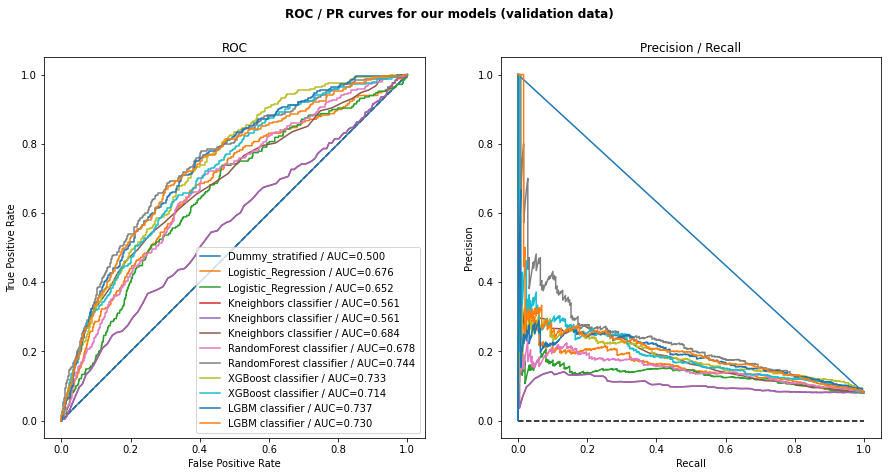

In [19]:
ROC_PR_curves(y1_test, y_pred_prob_list, df_summary_result1['model'])

##### Résultats : 

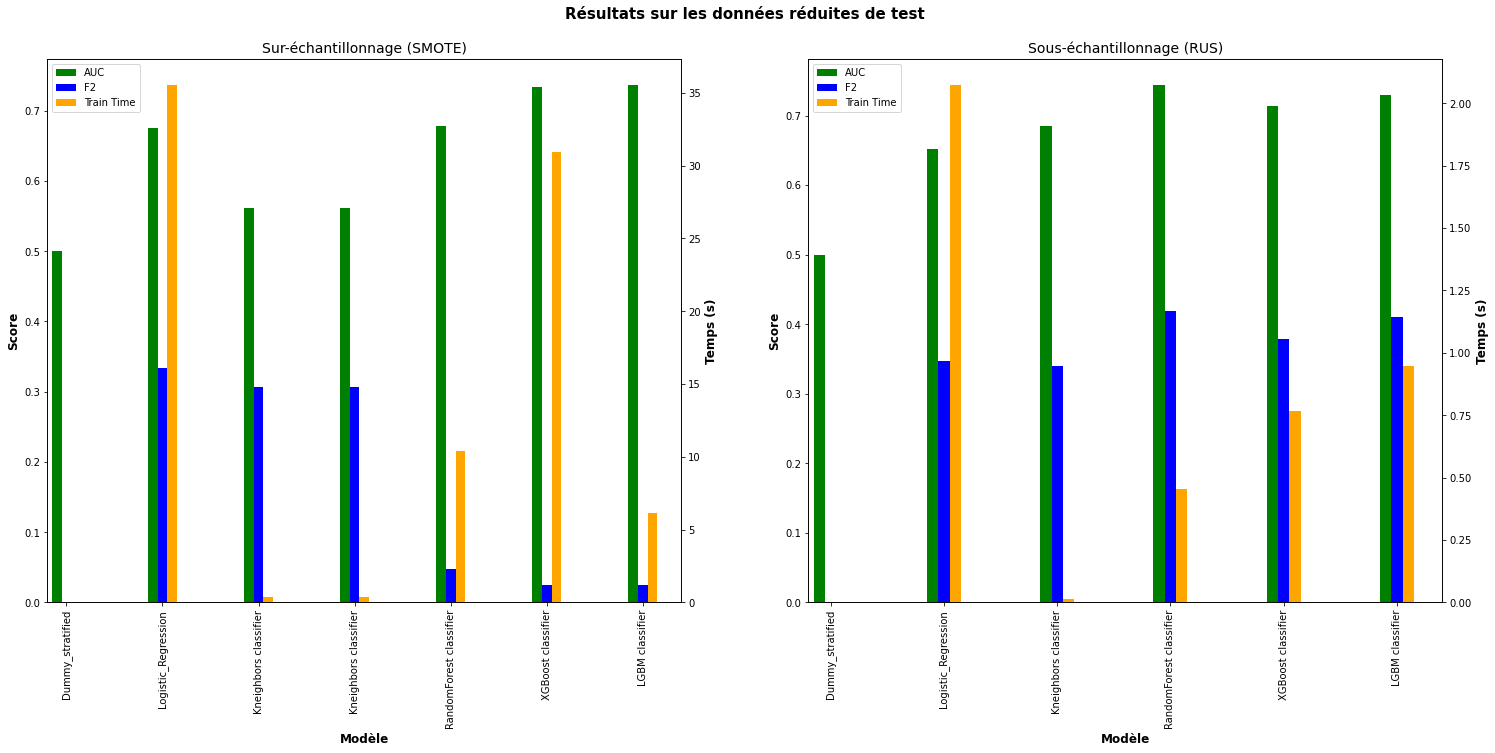

In [20]:
figure_bargraph = plt.figure(figsize=(25,10))
plt.axis('off')
plt.title('Résultats sur les données réduites de test', fontweight='bold', fontsize=15, pad=40)
ax = figure_bargraph.add_subplot(121) # Create matplotlib axes
ax2 = ax.twinx()
width = 0.10
plt.title('Sur-échantillonnage (SMOTE)', fontsize=14)
df_barg = df_summary_result1.set_index('model')
df_barg = df_barg.loc[(df_barg['Comment'] == 'test data score') | 
                      (df_barg['Comment'] == 'test data score with SMOTE(random_state=4) train data')]
df_barg['Score AUC'].plot(kind='bar',color='green', ax=ax, width=width, position=1.5)
df_barg['F2_score'].plot(kind='bar',color='blue', ax=ax, width=width, position=0.5)
df_barg['Train Time(s)'].plot(kind='bar',color='orange', ax=ax2, width=width, position=-0.5)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, ['AUC', 'F2', 'Train Time'], loc=2)
ax.set_xlabel('Modèle', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temps (s)', fontsize=12, fontweight='bold')
ax = figure_bargraph.add_subplot(122) # Create matplotlib axes
ax2 = ax.twinx()
width = 0.10
plt.title('Sous-échantillonnage (RUS)', fontsize=14)
df_barg = df_summary_result1.set_index('model')
df_barg = df_barg.loc[(df_barg['Comment'] == 'test data score') | 
                      (df_barg['Comment'] == 'test data score with RandomUnderSampler(random_state=4) train data')]
df_barg['Score AUC'].plot(kind='bar',color='green', ax=ax, width=width, position=1.5)
df_barg['F2_score'].plot(kind='bar',color='blue', ax=ax, width=width, position=0.5)
df_barg['Train Time(s)'].plot(kind='bar',color='orange', ax=ax2, width=width, position=-0.5)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, ['AUC', 'F2', 'Train Time'], loc=2)
ax.set_xlabel('Modèle', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temps (s)', fontsize=12, fontweight='bold')
plt.show()

--> Best scores are obtained with RUS and two models (RandomForest line 6 / LGBM line 10) seems to compete in terms of: <br>
* AUC scoring (it is our scoring method)
* Train time
* F2 score (interresting because it advantages the recall score over precision and this is what we want on our problematic)

 #### Validation scores for our two best models over all our data with RUS

In [21]:
# try to garbage X1 and y1 for memory usage
del X1, y1, X1_train, y1_train
gc.collect()

10085

In [22]:
# spliting and use our overall data
time_init = time.time()
# Data split (80% of train set)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=4)
# get X_train and X_test index
X_train_index = X_train.index
X_test_index = X_test.index
# Normalization of the imput data
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)
print (f'Time for Spliting and Normalize: {time.time() - time_init:.2f}')

Time for Spliting and Normalize: 7.50


In [23]:
# Trying our two RUS best model (line 5 and line 9 of our first results df_scores_CV5_1)
# defining new list for proba
summary_result1 = list()
y_pred_prob_list1 = list()
for i in [5, 9]:
    model = df_scores_CV5_1.iloc[i,3]
    time_init = time.time()
    model.fit(X_train, y_train)
    time_1 = time.time()
    y_pred_model = model.predict(X_test)
    time_2 = time.time()
    y_pred_prob_model = model.predict_proba(X_test)[:,1]
    # filling list with results for each models
    summary_result1.append({'model': df_scores_CV5_1.iloc[i, 0], 'Score AUC':roc_auc_score(y_test, y_pred_prob_model), 
                       'F1_score': f1_score(y_test, y_pred_model), 'F2_score': fbeta_score(y_test, y_pred_model, beta=2),
                        'Precision_score': precision_score(y_test,y_pred_model), 'Recall_score': recall_score(y_test, y_pred_model),
                       'Train Time(s)':df_scores_CV5_1.iloc[i, 4], 'Predict Time(s)': time_2 - time_1 , 'Comment': df_scores_CV5_1.iloc[i, 5]})
    y_pred_prob_list1.append(y_pred_prob_model)
df_summary_result2 = pd.DataFrame(summary_result1)
df_summary_result2

,model,Score AUC,F1_score,F2_score,Precision_score,Recall_score,Train Time(s),Predict Time(s),Comment
0,RandomForest classifier,0.698661,0.077787,0.054400,0.274390,0.045317,10.386787,1.409132,SMOTE(random_state=4) train data
1,LGBM classifier,0.747326,0.025376,0.016235,0.411392,0.013092,6.158206,0.749971,SMOTE(random_state=4) train data


##### ROC and Precision/Recall curves

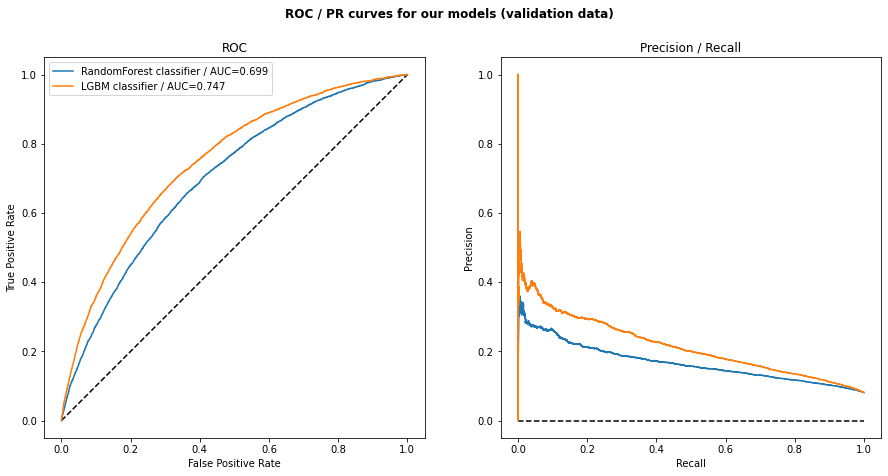

In [24]:
ROC_PR_curves(y_test, y_pred_prob_list1, df_summary_result2['model'])

--> Finalement , je choisis de conserver l'algorithme **LGBMClassifier**.
Les paramètres retenus sont::<br>
* n_estimator = 60
* max_depth = 7
* learning_rate = 0.1
* random_state=4 <br>

-->Nous allons essayer un GirdSearchCV autour de ces paramètres sur une métrique personnalisée avec ce modèle